# KIC 9651065

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
from maelstrom import Maelstrom
from astropy.stats import LombScargle
from lightkurve import search_lightcurvefile
import lightkurve as lk
from maelstrom.orbit import Orbit
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt

In [2]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 300

In [3]:
t, y = np.loadtxt('https://raw.githubusercontent.com/danhey/maelstrom/master/paper/lc/9651065_lc.txt', usecols=(0,1)).T

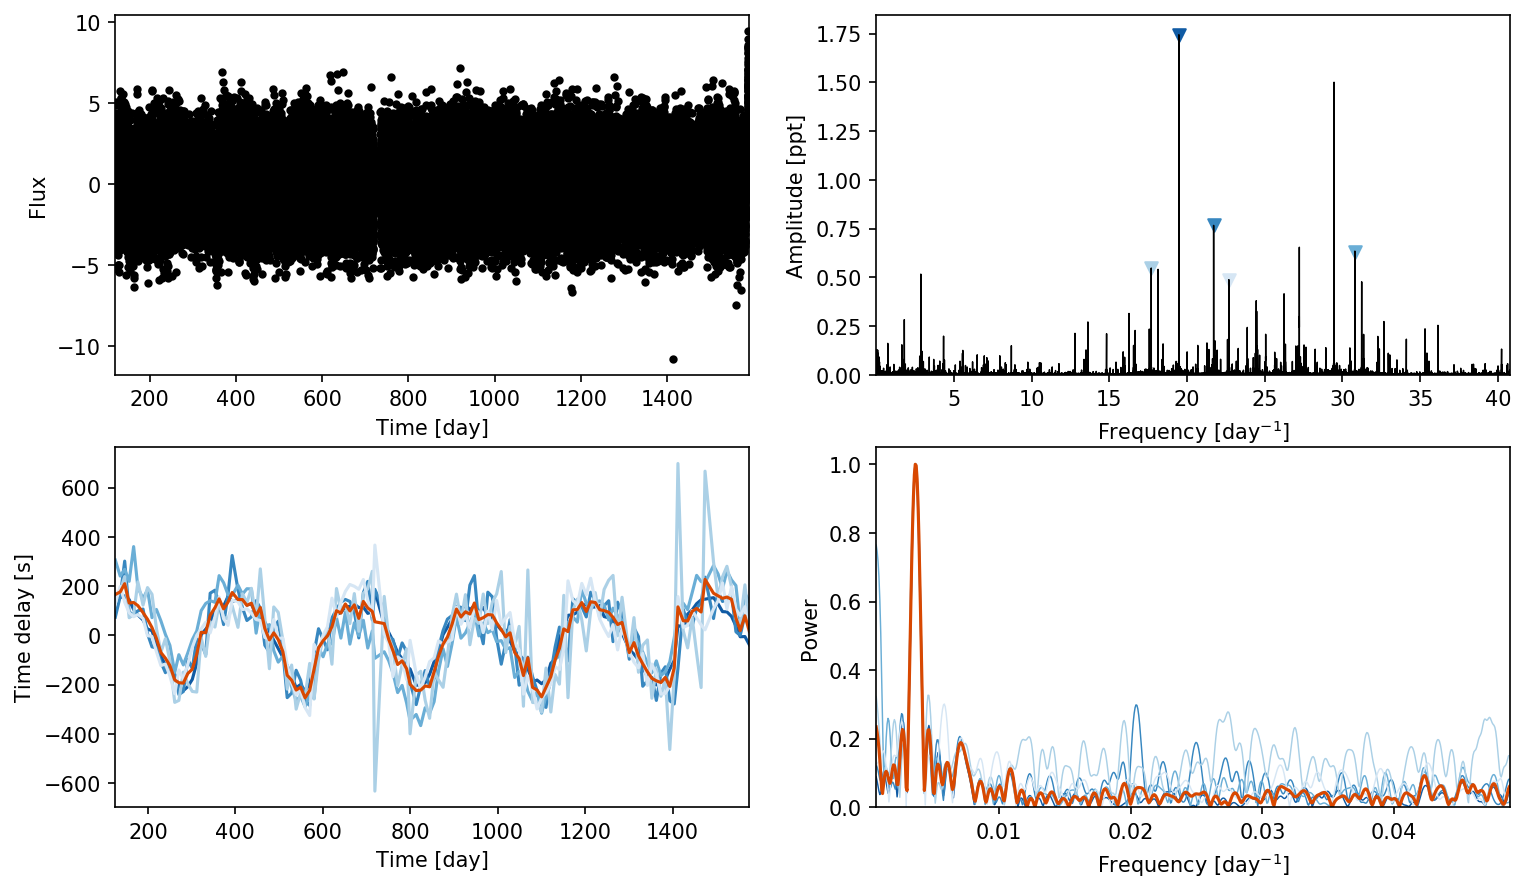

In [5]:
ms = Maelstrom(t, y, max_peaks=5, fmin=5, fmax=48)
ms.first_look();

In [4]:
period_guess = 300
a_guess = 200

time, flux = ms.time, ms.flux
freq = ms.freq
weights = ms.get_weights(norm=False)

In [5]:
pg = ms.period_search()

In [7]:
periods = np.linspace(100, 300, 300)
results = pg.fit(periods)

100%|██████████| 300/300 [10:05<00:00,  1.83s/it]


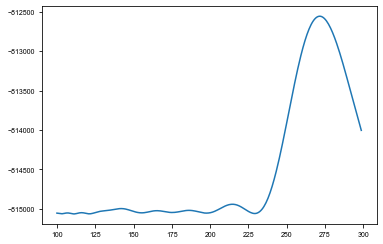

In [8]:
ys = np.array([[r[0] for r in row] for row in results])
sm = np.sum(ys, axis=0)
period_ind = np.argmax(sm)
plt.plot(periods[:-2], sm[:-2]);

In [19]:
from maelstrom.utils import unique_colors

hh = unique_colors(len(ms.freq), cmap='Blues')

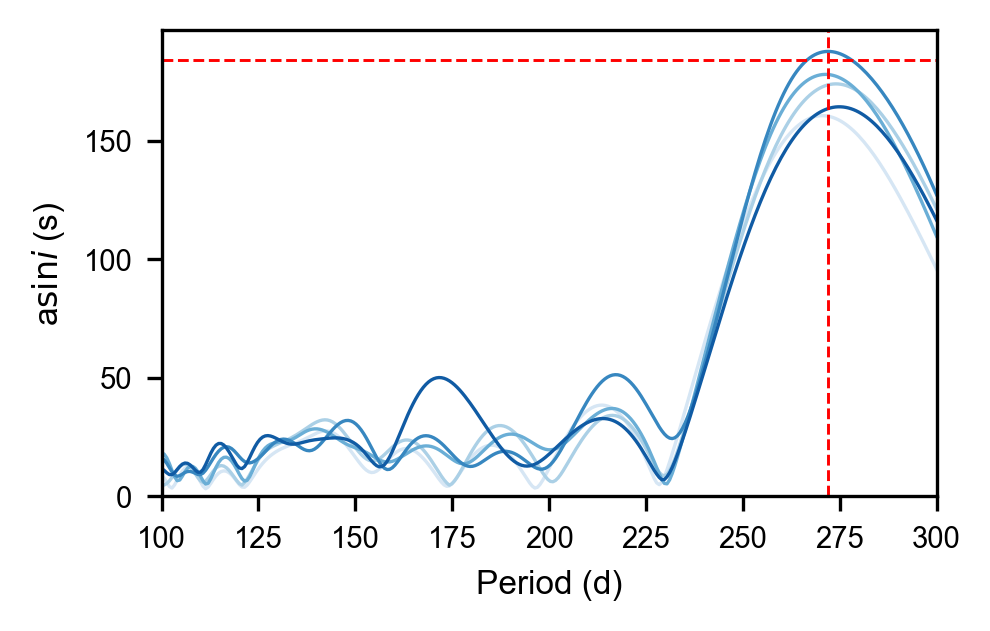

In [28]:
plt.figure(figsize=mnras_size(240.))

ys = np.array([[np.exp(r[1]["logasini"]) for r in row] for row in results])
for i, c in zip(ys, hh):
    plt.plot(periods, i, alpha=1, linewidth=0.8, c=c);

plt.xlabel('Period (d)')
plt.ylabel(r'a$\sin{i}$ (s)')
plt.ylim(0, None)
plt.xlim(100,300)
plt.axhline(184., c='r', linestyle='dashed', linewidth=0.7)
plt.axvline(272., c='r', linestyle='dashed', linewidth=0.7)

plt.savefig(overleaf_path + '9651065_period_search.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

## Maelstrom

In [5]:
ms.setup_orbit_model(period=period_guess)
# opt = ms.optimize()

In [6]:
pb1 = ms.pin_orbit_model()

In [9]:
opt = pb1.optimize()

optimizing logp for variables: [PB1_mean]
5it [00:00, 16.85it/s, logp=-1.065613e+05]
message: Optimization terminated successfully.
logp: -106561.27624942982 -> -106561.26306231941
optimizing logp for variables: [PB1_logs_lc]
9it [00:00, 20.45it/s, logp=-1.042264e+05]
message: Optimization terminated successfully.
logp: -106561.26306231941 -> -104226.39963321917
optimizing logp for variables: [PB1_omega, PB1_eccen]
181it [00:11, 15.14it/s, logp=-1.002360e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -104226.39963321917 -> -100236.02734631239
optimizing logp for variables: [PB1_phi]
21it [00:01, 15.82it/s, logp=-1.002145e+05]
message: Optimization terminated successfully.
logp: -100236.02734631239 -> -100214.47184126679
optimizing logp for variables: [PB1_lognu]
292it [00:17, 15.12it/s, logp=-1.002111e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -100214.47184126679 -> -100211.13341350148
optimizing logp for variabl

In [10]:
opt

{'PB1_logP_interval__': array(1.15567803),
 'PB1_phi_angle__': array([2.23436892, 3.87396393]),
 'PB1_logs_lc': array(0.11245058),
 'PB1_logasini_interval__': array(1.13126127),
 'PB1_mean': array(0.00050174),
 'PB1_lognu': array([2.96926915, 3.07787135, 3.42757632, 2.87353169, 3.12211358]),
 'PB1_omega_angle__': array([ 3.73297298, -2.46269836]),
 'PB1_eccen_interval__': array(-0.00997314),
 'PB1_logP': array(5.6068392),
 'PB1_period': array(272.28224574),
 'PB1_phi': array(0.52316012),
 'PB1_logasini': array(5.22275749),
 'PB1_asini': array(185.44484209),
 'PB1_nu': array([19.47767905, 21.71213556, 30.80189831, 17.69941683, 22.69429519]),
 'PB1_omega': array(2.1539708),
 'PB1_eccen': array(0.44775606)}

In [11]:
# with pb1:
#     trace = pm.load_trace('traces/9651065_FINAL_VERSION2/')

In [12]:
with pb1:
    trace = pm.sample(
        tune=1000,
        draws=2000,
        start=opt,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [PB1_eccen, PB1_omega, PB1_lognu, PB1_mean, PB1_logasini, PB1_logs_lc, PB1_phi, PB1_logP]
Sampling 2 chains: 100%|██████████| 6000/6000 [2:20:19<00:00,  2.26draws/s]  
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [13]:
pm.save_trace(trace, 'traces/NEW/9651065')

'traces/NEW/9651065'

In [7]:
with pb1:
    trace = pm.load_trace('traces/NEW/9651065')

In [9]:
pm.summary(trace)

mean            sd      mc_error     hpd_2.5    hpd_97.5  \
PB1_logs_lc     0.112488  2.788613e-03  4.318353e-05    0.107175    0.118011   
PB1_mean        0.000453  4.311418e-03  5.258491e-05   -0.008308    0.008533   
PB1_lognu__0    2.969269  6.947471e-08  1.007572e-09    2.969269    2.969269   
PB1_lognu__1    3.077871  1.401069e-07  1.790561e-09    3.077871    3.077872   
PB1_lognu__2    3.427576  1.153276e-07  1.482061e-09    3.427576    3.427577   
PB1_lognu__3    2.873532  2.410755e-07  3.310421e-09    2.873531    2.873532   
PB1_lognu__4    3.122114  2.028430e-07  3.086057e-09    3.122113    3.122114   
PB1_logP        5.606821  1.533627e-03  2.720497e-05    5.603934    5.609909   
PB1_period    272.277620  4.175774e-01  7.407073e-03  271.492266  273.119474   
PB1_phi         0.522492  6.838594e-02  1.535542e-03    0.387833    0.655864   
PB1_logasini    5.221896  1.943783e-02  2.706993e-04    5.183252    5.259797   
PB1_asini     185.320254  3.604021e+00  5.023618e-02  178.238043  192.418010   
PB1_nu__0      19.477679  1.353206e-06  1.962515e-08   19.477676   19.477682   
PB1_nu__1      21.712135  3.042020e-06  3.887691e-08   21.712129   21.712141   
PB1_nu__2      30.801898  3.552308e-06  4.565028e-08   30.801891   30.801905   
PB1_nu__3      17.699417  4.266896e-06  5.859252e-08   17.699409   17.699425   
PB1_nu__4      22.694295  4.603379e-06  7.003588e-08   22.694286   22.694304   
PB1_omega       2.152293  6.991323e-02  1.443976e-03    2.009589    2.279623   
PB1_eccen       0.446589  3.034053e-02  3.954959e-04    0.387161    0.507217   

                    n_eff      Rhat  
PB1_logs_lc   4872.309174  0.999766  
PB1_mean      4733.853954  0.999893  
PB1_lognu__0  4877.899058  0.999750  
PB1_lognu__1  4987.425769  0.999809  
PB1_lognu__2  5116.923872  0.999820  
PB1_lognu__3  5273.564497  0.999758  
PB1_lognu__4  5007.746307  1.000491  
PB1_logP      3794.642416  1.000395  
PB1_period    3795.598300  1.000395  
PB1_phi       2230.647368  1.000448  
PB1_logasini  4904.909828  0.999750  
PB1_asini     4901.764291  0.999751  
PB1_nu__0     4877.899053  0.999750  
PB1_nu__1     4987.425756  0.999809  
PB1_nu__2     5116.923857  0.999820  
PB1_nu__3     5273.564233  0.999758  
PB1_nu__4     5007.746310  1.000491  
PB1_omega     2570.133760  0.999965  
PB1_eccen     4711.494926  0.999955

In [10]:
from tqdm import tqdm

taus = []
with pb1:
    for samp in tqdm(xo.utils.get_samples_from_trace(trace, size=1000), total=1000):
            taus.append(xo.eval_in_model(pb1.orbit.get_time_delay(time), samp) * 86400)

100%|██████████| 1000/1000 [03:09<00:00,  5.29it/s]


In [24]:
med_td = np.median(taus, axis=0)
sd_td = np.std(taus, axis=0)

In [27]:
mean = np.mean(taus)
mean

108.12878089572754

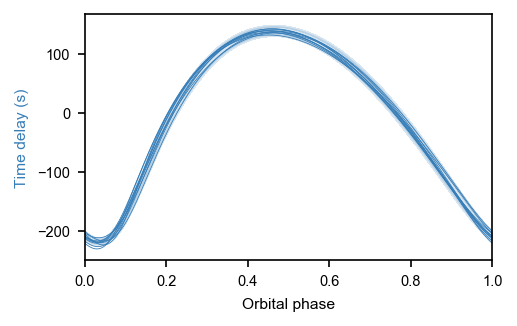

In [29]:
np.random.seed(23)
fig, ax = plt.subplots(figsize=mnras_size(240), constrained_layout=True)

ax.set_rasterized(True)
#ax.set_rasterization_zorder(1)

with pb1:
    for samp in xo.utils.get_samples_from_trace(trace, size=10):
        taumod = xo.eval_in_model(pb1.orbit.get_time_delay(time), samp) * 86400
        #ttime = (ms.time_mid + time - samp['tref']) % samp['period'] / samp['period']
        ttime = (time) % samp['PB1_period'] / samp['PB1_period']
        #ttime = ((ms.time_mid + time) + (samp['phi'] * samp['period'] / (2*np.pi))) % samp['period'] / samp['period']
        sort = np.argsort(ttime)
        ax.plot(ttime[sort], (taumod - np.mean(taumod))[sort], color=blue, linewidth=0.4, alpha=1, 
#                 rasterized=True,
                zorder=1)


ax.set_xlabel('Orbital phase')
ax.set_ylabel('Time delay (s)', c=blue)


times = time# + xo.eval_in_model(phi * period / (2*np.pi), samp)
fold = times % np.median(trace['PB1_period']) / np.median(trace['PB1_period'])
sort = np.argsort(fold)
plt.fill_between(fold[sort], (med_td - sd_td - 108.12878089572754)[:,0][sort], (med_td+sd_td - 108.12878089572754)[:,0][sort], alpha=0.2, color=blue)


ax.set_xlim(0, 1)

plt.savefig(overleaf_path + '9651065.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
#plt.savefig('rast.pdf', dpi=300, bbox_inches='tight')

In [37]:
from maelstrom.utils import mass_function
import astropy.units as u
rounding = 3
samples = pm.trace_to_dataframe(trace, varnames=['PB1_period', 'PB1_asini'])
mfs = mass_function(samples['PB1_period'].values * u.day, samples['PB1_asini'].values*u.s)
#mfs = np.array(mfs)
upper, med, lower = np.percentile(mfs.value, [84.13, 50, 15.86])
print('mass_func', ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

mass_func :  0.092  +  0.006  -  0.005


In [48]:
varnames = ["period", "asini", "eccen", "omega", "phi"]
for var in varnames:
    percentiles = np.percentile(trace['PB1_' + var], q=[15.87, 50, 84.13])
    print(f'{var}: {percentiles[0]:.2f} + {percentiles[1] - percentiles[0]:.2f} - {percentiles[2] - percentiles[1]:.2f}')

period: 271.86 + 0.42 - 0.42
asini: 181.74 + 3.48 - 3.70
eccen: 0.42 + 0.03 - 0.03
omega: 2.08 + 0.07 - 0.07
phi: 0.45 + 0.07 - 0.07


## Subdividing

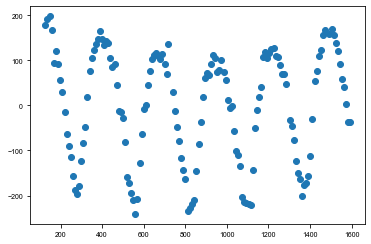

In [5]:
td_time, td_td, td_err = np.loadtxt('../data/kic9651065_uncertainties-plus-time-delay_Q99_llc.txt', delimiter=',', usecols=(0,1,2)).T
td_time += 2400000
td_time -= 2454833
plt.scatter(td_time, td_td)

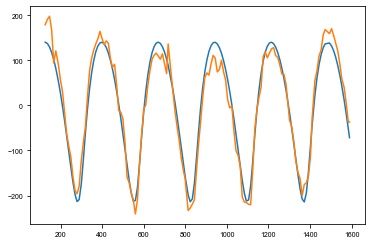

In [17]:
import theano.tensor as tt
from maelstrom.orbit import Orbit

with pm.Model() as subdivide_model:
    logP = pm.Normal("logP", mu=np.log(272), sd=1.0, testval=np.log(272))
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi", testval=0.5691498)
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=0.)
    logasini = pm.Normal('logasini', mu=np.log(184), sd=10, testval=np.log(184))
    asini = pm.Normal("asini", mu=184, sd=10, testval=184)
    drift = pm.Normal('drift', mu=0., sd=0.1, testval=0)
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=-0.94)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=0.9, testval=0.45)
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    # Here, we generate an Orbit instance and pass in our priors. 
    orbit = Orbit(period=period, 
                  lighttime=asini, 
                  omega=omega, 
                  eccen=eccen, 
                  phi=phi, 
                  freq=0)
    
    # psi is defined to be negative but the light curve model takes 2*pi*f * (time - tau), so 
    # we must flip tau here to phase it on the same values
    td = -1*tt.squeeze(orbit.get_time_delay(td_time) * 86400) # Convert to s
    td += drift * td_time
    taumodel = pm.Deterministic('taumodel', td - tt.mean(td))
    
    pm.Normal('obs', mu=taumodel, sd=tt.exp(logs_lc), observed=td_td)
    
    plt.plot(td_time, xo.eval_in_model(taumodel))
    plt.plot(td_time, td_td)

In [18]:
with subdivide_model:
    opt = xo.optimize()

optimizing logp for variables: [mean, eccen, omega, drift, asini, logasini, logs_lc, phi, logP]
232it [00:00, 388.50it/s, logp=-6.434439e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -48164.10895929657 -> -643.4438767879074


In [19]:
opt

{'logP': array(5.60714099),
 'phi_angle__': array([2.10553359, 3.94546931]),
 'logs_lc': array(3.23034851),
 'logasini': array(5.21493576),
 'asini': array(184.58303002),
 'drift': array(-0.01031364),
 'omega_angle__': array([-3.79526569,  2.36557775]),
 'eccen_interval__': array(0.0158198),
 'mean': array(2.38628165e-07),
 'period': array(272.36443175),
 'phi': array(0.49021052),
 'omega': array(-1.01342257),
 'eccen': array(0.45355938),
 'taumodel': array([ 147.24755677,  144.46279379,  137.15584656,  125.61074901,
         110.08619756,   90.85808226,   62.69573976,   35.92242968,
           6.16179366,  -25.77210035,  -61.20875403,  -97.26770722,
        -133.55915693, -167.94415079, -196.48908661, -212.07208628,
        -204.22591848, -167.13862369, -111.34753077,  -53.28526181,
          -1.56577971,   41.49527278,   75.96300517,  102.54463349,
         122.02595761,  134.79244776,  142.52189448,  144.40171533,
         141.41386885,  133.9053782 ,  122.17152656,  106.46937425,
 

In [20]:
with subdivide_model:
    trace = pm.sample(draws=2000, tune=2000, chains=2, start=opt)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mean, eccen, omega, drift, asini, logasini, logs_lc, phi, logP]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:44<00:00, 181.50draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [23]:
pm.summary(trace)

mean         sd  mc_error     hpd_2.5    hpd_97.5  \
logP             5.607095   0.001736  0.000027    5.603561    5.610316   
logs_lc          3.254204   0.059783  0.000971    3.142328    3.370083   
logasini         5.158147  10.329290  0.160456  -15.967711   24.618398   
asini          184.445995   3.870201  0.063553  176.857801  191.948600   
drift           -0.010248   0.005162  0.000092   -0.019934    0.000135   
...                   ...        ...       ...         ...         ...   
taumodel__139   41.362412   5.391437  0.094788   30.918199   51.678708   
taumodel__140   11.103050   5.694254  0.098105    0.322530   22.302191   
taumodel__141  -19.752772   6.019379  0.100769  -32.273483   -8.936965   
taumodel__142  -53.100596   6.392202  0.103530  -66.166348  -41.560302   
taumodel__143  -73.611650   6.629763  0.105464  -87.166013  -61.474205   

                     n_eff      Rhat  
logP           3361.652808  1.000854  
logs_lc        3278.874473  1.000252  
logasini       4166.228593  0.999801  
asini          3506.022622  0.999973  
drift          3809.751947  0.999920  
...                    ...       ...  
taumodel__139  3490.961696  1.000202  
taumodel__140  3488.877638  1.000171  
taumodel__141  3567.415216  1.000086  
taumodel__142  3850.340893  0.999968  
taumodel__143  4059.883054  0.999896  

[154 rows x 7 columns]

In [24]:
varnames=['period', 'phi', 'eccen', 'asini', 'omega', 'phi', 'drift']
rounding = 2
for varname in varnames:
    upper, med, lower = np.percentile(trace[varname], [84.13, 50, 15.86])
    print(varname, ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

period :  272.35  +  0.47  -  0.46
phi :  0.49  +  0.08  -  0.08
eccen :  0.45  +  0.03  -  0.03
asini :  184.37  +  3.89  -  3.72
omega :  -1.02  +  0.08  -  0.08
phi :  0.49  +  0.08  -  0.08
drift :  -0.01  +  0.01  -  0.0


In [30]:
from maelstrom.utils import mass_function
import astropy.units as u
rounding = 3
samples = pm.trace_to_dataframe(trace, varnames=['period', 'asini'])
mfs = mass_function(samples['period'].values * u.day, samples['asini'].values*u.s)
#mfs = np.array(mfs)
upper, med, lower = np.percentile(mfs.value, [84.13, 50, 15.86])
print('mass_func', ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

mass_func :  0.091  +  0.006  -  0.005


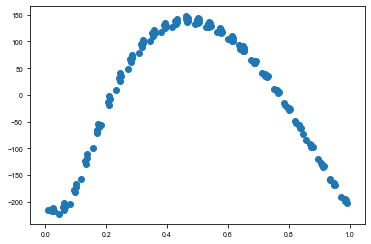

In [29]:
plt.scatter(td_time % 272 / 272, np.median(trace['taumodel'], axis=0))